In [39]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

from uncertainties import ufloat

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

#find stellar distance for LMC stars based on Van Der Marel 2001 (eq 8)
# def dist2LMC(ra, dec):
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 = np.radians(ra1)
#     dec1 = np.radians(dec1)
#     alph0 = np.radians(82.25) #ra of LMC center
#     delt0 = np.radians(-69.5) #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     io = np.radians(25.86) #inclination #27.81
#     pa = np.radians(149.37+90)  #position angle of line-of-nodes
#     cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
#     sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
#     sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
#     return dis

# Modified version of the above to test 
def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [40]:
###################
### Import Data ###
###################

#Read in all MIST file
mist = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmist = Table.from_pandas(mist)
rgb = np.where((tmist['EEP']>=495)&(tmist['EEP']<=605)&(tmist['log_Teff']<=3.75))
trgb = tmist[rgb]

#DR 16 with distances in DIST column
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['LOGG']<2.0)&(lmcdr16['M_H_ERR']>-90.0))
clndr16 =lmcdr16[clnr]

#Feuillet Bayesian
feuillet1 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' 
pdfout = fits.getdata(feuillet1, 1)

In [41]:
######################
### Model for MIST ###
######################

'''
x1: logT
x2: K
x3: feh
x4: logg
'''

# def bestmist(x1,x2,x3,x4):
#     p = [11.95633625,4.29637009,3.47288991,0.24495181,-6.09562956,-0.61658645,-0.69137712,0.14681993,0.06654658,\
#          0.82262236]
#     return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x2,x4)+p[7]*(x2**2)+\
# p[8]*(x3**2)+p[9]*(x4**2)

def bestmist(x1,x2,x3,x4):
    p = [11.95633625,  4.29637009,  3.47288991,  0.24495181, -6.09562956,\
       -0.61658645, -0.69137712,  0.14681993,  0.06654658,  0.82262236]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x4)+p[6]*np.multiply(x2,x4)+\
p[7]*(x2**2)+p[8]*(x3**2)+p[9]*(x4**2)

In [42]:
#####################
### MIST Age Calc ###
#####################

absK = absmag(clndr16['K'],clndr16['DIST'],False)-clndr16['AK_TARG']
salfeh = sal(clndr16['M_H'],clndr16['ALPHA_M'])
m_age = bestmist(np.log10(clndr16['TEFF']),absK,salfeh,clndr16['LOGG'])

$\huge{\textbf{Uncertainty}}$

In [43]:
#################
### Add Noise ###
#################

from scipy.stats import skewnorm, skew
from scipy.special import erf

def mad(dat):
    return np.median(np.absolute(dat-np.median(dat)))

def noisy(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,lgg,lggERR):
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    aMnoise = np.random.normal(0, amERR) #[alpha/M]
    gnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = am + ((-1)**np.random.randint(2))*aMnoise
    gnew = lgg + ((-1)**np.random.randint(2))*gnoise
    return Tnew, Knew, MHnew, aMnew, gnew

In [33]:
#########################
### Get Uncertainties ###
#########################

clndr16 = lmcdr16[clnr]
allstars = []
allstarsERR = []
devs = []
MSPE = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = absK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    am = clndr16['ALPHA_M'][i]
    amERR = clndr16['ALPHA_M_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nam,nlgg = noisy(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,lgg,lggERR)
        ages.append(bestmist(nlgT,nks,sal(nmh,nam),nlgg))
    
    devs.append(mad(ages))

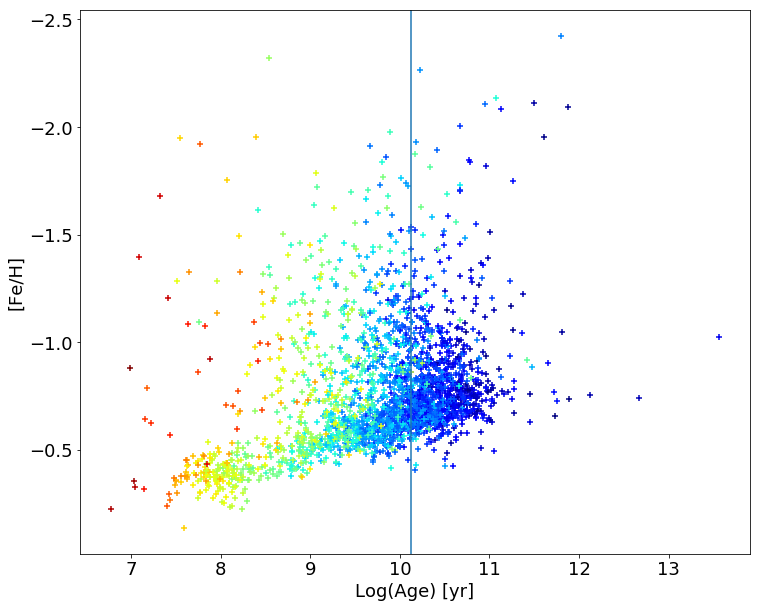

In [34]:
#Age Metallicity Plot
plt.figure(figsize=[12,10])
plt.scatter(m_age,clndr16['FE_H'],marker='+',c=clndr16['LOGG'],cmap='jet')
plt.axvline(x=np.log10(ageU))
plt.gca().invert_yaxis()
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'[Fe/H]')
plt.show()

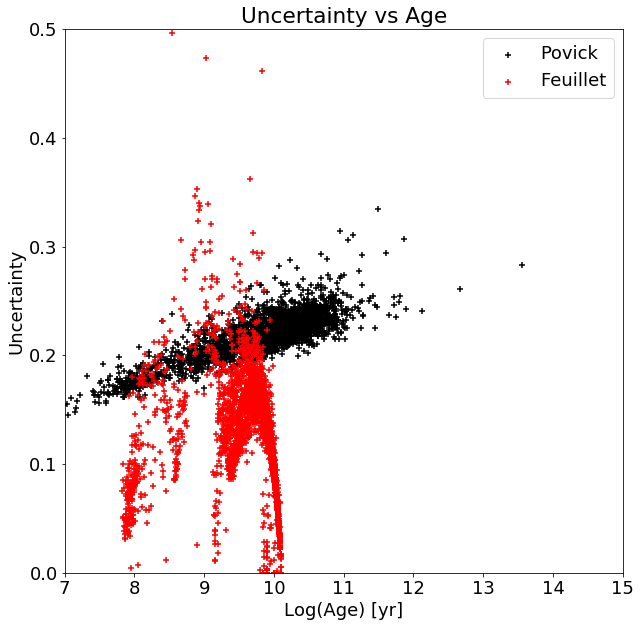

In [37]:
#Age Uncertainty Plot
plt.figure(figsize=[10,10])
plt.scatter(m_age,devs,c='k',marker='+',label='Povick')
plt.scatter(pdfout['P_MEAN'],pdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.xlim(7,15)
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty')
plt.ylim(0.0,0.5)
plt.title(r'Uncertainty vs Age')
plt.legend()
plt.savefig('uncert_age.pdf',bbox_inches='tight')
plt.show()

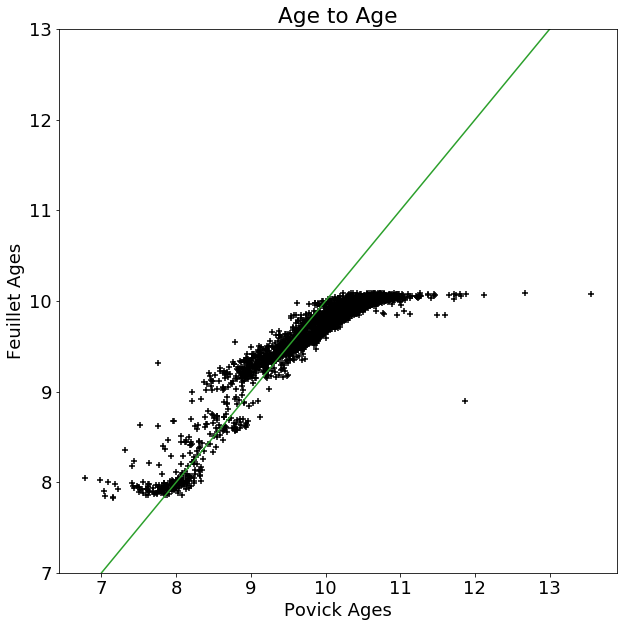

In [36]:
#Age-2-Age Plot
plt.figure(figsize=[10,10])
plt.scatter(m_age,pdfout['P_MEAN'][clnr],c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Feuillet Ages')
plt.title(r'Age to Age')
plt.savefig('age_age.pdf',bbox_inches='tight')
plt.show()

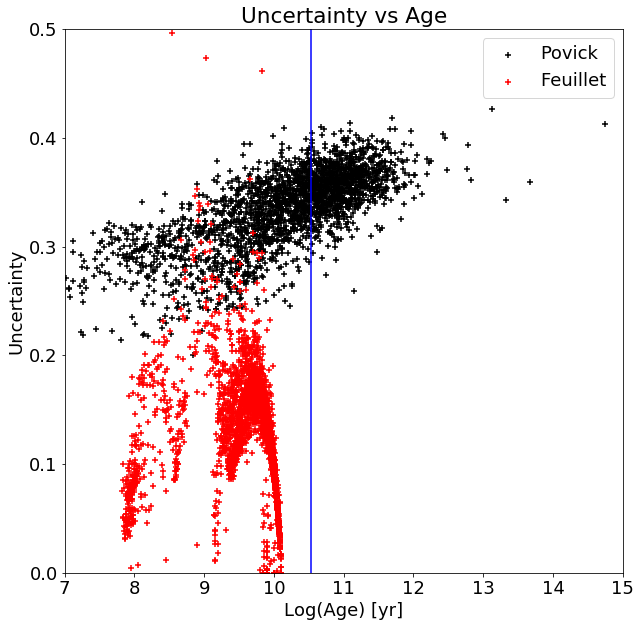

In [63]:
#Age Uncertainty Plot
plt.figure(figsize=[10,10])
plt.scatter(agestransform,devs,c='k',marker='+',label='Povick')
plt.scatter(pdfout['P_MEAN'],pdfout['P_VAR'],c='r',marker='+',label='Feuillet')
plt.axvline(10.53,c='blue')
plt.xlim(7,15)
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty')
plt.ylim(0.0,0.5)
plt.title(r'Uncertainty vs Age')
plt.legend()
plt.savefig('uncert_age.pdf',bbox_inches='tight')
plt.show()